ECR multi-week planning
=====================

The ECR call center has about 200 agentswith the following contract types:

- 50% part-time: thet work 4 hours
- 75% part-time: they work 6 hours
- full-time: they work 8 hours

A plan is made each week based on the call forecast based on the following rules

- agents work from monday to sunday
- they work on 4,6,8 hours shifts based on their contract
- agent can choose an entry time window

---

- there are 3 kind of rest assignment pattern: 

| name         | description                                           |
|--------------|-------------------------------------------------------|
| *weekend*    | rest is assigned on sat and sun                       |
| *split-rest* | rest is assigned on sun an on one other day mon-thu   |
| *infra-week* | rest is assigned on two consecutive week days mon-sat |


- on the very first week the agent can be assigned any kind
- on the following weeks the rest rotation rule is weekend -> infra-week -> split-rest -> weekend

---

- the plan must be **optimal** that is it must follow as closely as possible the target

---

In order to specify these rules we use a simple *domain specific language*:

- **shifts** are defined based on a specification line: for example

```
A1 = Shift.fromSpec("A1", "09:00-12:00")             # a 4 hour shift from 9 to 12
A2 = Shift.fromSpec("A2", "10:00-13:00")             # a 4 hour shift from 9 to 12
...
M1 = Shift.fromSpec("M1", "09:00-12:00,13:00-17:00") # a 8 hour shift from 9 to 17 with a 1 hour pause
...
R  = Shift("R")                                      # a rest shift
```

- shifts can be *combined* to form **shift rules**

```
A1 + A2      # assign either A1 or A2 on a single day

A1 * A2      # a two day assigment: assign A1 on the first day and A2 on the second

(A1+A2) * R  # a two day assignment: assign either A1 or A2 on the first day and R on the second


W = A1 + A2

X = W * W * W * W * W * R * R    # a 7 days assignment:
                                 #   assign either A1 or A2 on the first 5 days
                                 #   assign R on the weekend
```

---

To produce a plan we have to

- define the shifts and the agents and the target staffing
- based on the contract, availability, etc. we find the shifts that can be assigned to an agent
- we create a planner
- we form the shift rules and add them to the planner
- we run the planner
- we retrieve the optimized plan

In [1]:
import re
import json
import matplotlib.pyplot as plt

from datetime import time
from random import randint
from functools import reduce
from tabulate import tabulate

from pywfplan import Shift, StaffPlanner

In [2]:
# first we import the shift specifications
# note that the pauses are specified in the shift definition

with open("shifts_ecr.json") as f:
        shifts = [Shift.fromSpec(s[0], *s[1]) for s in json.load(f).items()]

In [3]:
# we implement a function to retrieve the shifts that can be assigned to an agent

def work_shifts_for_agent(agent):
    p = re.compile("^(\d\d):(\d\d)$")
    
    m0 = p.match(agent["from"])
    m1 = p.match(agent["to"])
    
    t0 = time(hour=int(m0.group(1)), minute=int(m0.group(2)))
    t1 = time(hour=int(m1.group(1)), minute=int(m1.group(2)))

    # during the week agents can be assigned shifts in a 1 hour window around their chosen time `t0`
    agent_shifts = [s for s in shifts if s.is_work() and s.attrs["contract"] == agent["contract"] and t0 <= s.start_time() and s.start_time() <= t1]
    
    return reduce(lambda a,b: a+b, agent_shifts)

In [4]:
# the rest shift

R = Shift.fromSpec("R")

In [5]:
# the the agent definitions

with open("agents_ecr.json") as f:
        agents = json.load(f)

len(agents)

129

In [6]:
# initialize cycles

cycle = {agent: randint(0,3) for agent in agents}

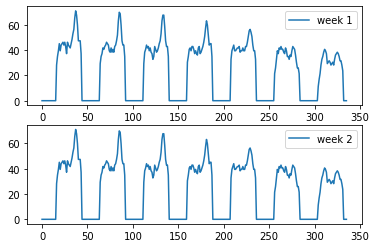

In [7]:
# the target curves from the call forecast
with open("target_ecr.json") as f:
        target = json.load(f)

# rescale
N1 = 4042.5 / (sum(target["week1"])*30/60)
target["week1"] = [t * N1 for t in target["week1"]]

N2 = 4042.5 / (sum(target["week2"])*30/60)
target["week2"] = [t * N2 for t in target["week2"]]
        
plt.subplot(2, 1, 1)
plt.plot(target["week1"], label="week 1")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(target["week2"], label="week 2")
plt.legend()


Week 1
----------

In [8]:
# create a planner for the first week

week1Planner = StaffPlanner()

In [9]:
# configure the planner

week1Planner.setStaffingTarget(target["week1"], days=7, slot_length=30)

for code, agent in agents.items():
    
    # W is the work shift that can be assigned on woork days
    W = work_shifts_for_agent(agent)
    
    if cycle[code] == 0:
        # weekend
        rule = W * W * W * W * W * R * R

    elif cycle[code] == 1 or cycle[code] == 2:
        # infra-week
        iw1 = W * W * W * W * R * R * W
        iw2 = W * W * W * R * R * W * W
        iw3 = W * W * R * R * W * W * W
        iw4 = W * R * R * W * W * W * W
        iw5 = R * R * W * W * W * W * W
        rule  = iw1 + iw2 + iw3 + iw4 + iw5

    elif cycle[code] == 3:
        # split-rest
        sr1 = W * W * W * W * R * W * R
        sr2 = W * W * W * R * W * W * R
        sr3 = W * W * R * W * W * W * R
        sr4 = W * R * W * W * W * W * R
        sr5 = R * W * W * W * W * W * R
        rule  = sr1 + sr2 + sr3 + sr4 + sr5
    
    # finally we add the rule to the planner
    week1Planner.addAgentRule(code, rule)

In [10]:
# at this point the planner is ready to be launched
# (it takes a few minutes)

week1Planner.run(annealing_schedule=0.85, comfort_energy_weight=0.0)

performing initial temperature calibration ...
initial temperature: 16.000000
performing final temperature calibration ...
final temperature: 0.000050
starting 78 simulated annealing steps from temperature 16.0000 (delta=0.8500) ...
  1% T=16.0000 E=149.5043 (2581 2687) ...
  2% T=13.6000 E=150.8681 (2581 2726) ...
  3% T=11.5600 E=170.6864 (2581 2765) ...
  5% T=9.8260 E=117.6967 (2581 2769) ...
  6% T=8.3521 E=153.1055 (2581 2806) ...
  7% T=7.0993 E=128.9183 (2581 2796) ...
  8% T=6.0344 E=121.7165 (2581 2867) ...
 10% T=5.1292 E=131.1970 (2581 2892) ...
 11% T=4.3598 E=135.8190 (2581 2974) ...
 12% T=3.7059 E=119.6086 (2581 3005) ...
 14% T=3.1500 E=109.8690 (2581 3166) ...
 15% T=2.6775 E=96.4725 (2581 3186) ...
 16% T=2.2759 E=111.0962 (2581 3338) ...
 17% T=1.9345 E=87.3235 (2581 3478) ...
 19% T=1.6443 E=81.1752 (2581 3563) ...
 20% T=1.3977 E=68.8512 (2581 3744) ...
 21% T=1.1880 E=59.4949 (2581 3917) ...
 23% T=1.0098 E=60.6844 (2581 4115) ...
 24% T=0.8583 E=47.7140 (2581 42

In [11]:
# retrieve the optimized plan

print(tabulate([[code, agents[code]["contract"], *week1Planner.getAgentPlan(code)] for code in agents], 
               headers=["agent", "contract", "sun", "mon", "tue", "wed", "thu", "fri", "sat", "sun"]))

agent       contract    sun    mon    tue    wed    thu    fri    sat
----------  ----------  -----  -----  -----  -----  -----  -----  -----
T200000641  T75         R      F1     F1     F1     F1     F1     R
T200000883  T100        P58    R      R      Q8     Q8     M68    P52
T200000987  T50         A3     A1     C5     R      R      A3     A3
T200001433  T50         C5     C5     C5     C5     C5     R      R
T200001435  T50         A1     A1     A1     A1     R      R      A3
T200001496  T75         F1     D1     R      F1     F1     F1     R
T200001545  T50         A5     A5     A5     A5     R      A5     R
T200001909  T75         D3     E6     D3     D3     E7     R      R
T200002005  T75         R      R      D1     D1     D1     D1     D2
T200002012  T100        P51    P13    R      R      P58    M31    P52
T200002084  T100        P58    R      R      P52    P51    P52    P52
T200002100  T100        P52    P58    R      R      P51    Q8     Q8
T200002196  T75         D1     D

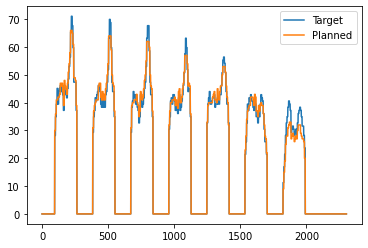

In [12]:
# and compare the planned staffing curve with the target

plt.plot(week1Planner.getTargetStaffing(), label="Target")
plt.plot(week1Planner.getPlannedStaffing(), label="Planned")
plt.legend()
plt.show()

In [13]:
# the optimization report 

print(week1Planner.getReport())


          turning length: 7
                 week n°: 0
             slot length: 5 minutes
               agents n°: 129
         target staffing: 4042.50 hrs
      simulated staffing: 4042.50 hrs

   comfort energy weight: 0.00000

         annealing steps: 78
       temperature range: 16.00000 -> 0.00005
    temperature schedule: 0.85
       optimization time: 4.2 minutes

         staffing energy: 178.53853 -> 4.15981
          comfort energy: 60366.85714 -> 129234.85714
            TOTAL ENERGY: 178.53853 -> 4.15981

     day by day staffing:
                 day   1: 666.50 hrs (target 657.29 hrs error -1.40%)
                 day   2: 644.50 hrs (target 630.78 hrs error -2.18%)
                 day   3: 629.50 hrs (target 617.80 hrs error -1.89%)
                 day   4: 612.50 hrs (target 603.13 hrs error -1.55%)
                 day   5: 603.50 hrs (target 598.62 hrs error -0.82%)
                 day   6: 508.00 hrs (target 499.32 hrs error -1.74%)
                 day   7:

In [14]:
# save plan for later

week1Plan = {code: week1Planner.getAgentPlan(code) for code in agents}

In [15]:
# update cycle

for agent in agents:
    cycle[agent] = (cycle[agent] + 1) % 4

Week 2
----------

In [16]:
# create a new planner for the second week

week2Planner = StaffPlanner()

In [17]:
# configure the planner

week2Planner.setStaffingTarget(target["week2"], days=7, slot_length=30)

for code, agent in agents.items():
    
    # W is the work shift that can be assigned on work days
    W = work_shifts_for_agent(agent)
    
    if cycle[code] == 0:
        # weekend
        rule = W * W * W * W * W * R * R

    elif cycle[code] == 1 or cycle[code] == 2:
        # infra-week
        iw1 = W * W * W * W * R * R * W
        iw2 = W * W * W * R * R * W * W
        iw3 = W * W * R * R * W * W * W
        iw4 = W * R * R * W * W * W * W
        iw5 = R * R * W * W * W * W * W
        rule  = iw1 + iw2 + iw3 + iw4 + iw5

    elif cycle[code] == 3:
        # split-rest
        sr1 = W * W * W * W * R * W * R
        sr2 = W * W * W * R * W * W * R
        sr3 = W * W * R * W * W * W * R
        sr4 = W * R * W * W * W * W * R
        sr5 = R * W * W * W * W * W * R
        rule  = sr1 + sr2 + sr3 + sr4 + sr5
    
    # finally we add the rule to the planner
    week2Planner.addAgentRule(code, rule)

In [18]:
# run planner

week2Planner.run(annealing_schedule=0.85, comfort_energy_weight=0.0)

performing initial temperature calibration ...
initial temperature: 16.000000
performing final temperature calibration ...
final temperature: 0.000141
starting 72 simulated annealing steps from temperature 16.0000 (delta=0.8500) ...
  1% T=16.0000 E=132.2188 (2581 2693) ...
  2% T=13.6000 E=143.1035 (2581 2717) ...
  4% T=11.5600 E=160.4711 (2581 2730) ...
  5% T=9.8260 E=138.2924 (2581 2753) ...
  6% T=8.3521 E=142.8797 (2581 2810) ...
  8% T=7.0993 E=146.3092 (2581 2850) ...
  9% T=6.0344 E=123.2962 (2581 2890) ...
 11% T=5.1292 E=134.2388 (2581 2907) ...
 12% T=4.3598 E=126.0300 (2581 2981) ...
 13% T=3.7059 E=102.8171 (2581 3041) ...
 15% T=3.1500 E=80.5088 (2581 3145) ...
 16% T=2.6775 E=91.8658 (2581 3215) ...
 18% T=2.2759 E=126.0545 (2581 3380) ...
 19% T=1.9345 E=91.2822 (2581 3459) ...
 20% T=1.6443 E=76.7647 (2581 3566) ...
 22% T=1.3977 E=64.0935 (2581 3759) ...
 23% T=1.1880 E=47.5186 (2581 3972) ...
 25% T=1.0098 E=49.6417 (2581 4141) ...
 26% T=0.8583 E=52.6683 (2581 431

In [19]:
# retrieve the optimized plan

print(tabulate([[code, agents[code]["contract"], *week2Planner.getAgentPlan(code)] for code in agents], 
               headers=["agent", "contract", "sun", "mon", "tue", "wed", "thu", "fri", "sat", "sun"]))

agent       contract    sun    mon    tue    wed    thu    fri    sat
----------  ----------  -----  -----  -----  -----  -----  -----  -----
T200000641  T75         F1     F1     F1     F1     F1     R      R
T200000883  T100        P51    P51    R      R      P52    Q5     P52
T200000987  T50         C2     A3     A1     R      A1     A2     R
T200001433  T50         C5     C5     C5     R      R      C5     C5
T200001435  T50         A3     A1     A1     A1     R      A3     R
T200001496  T75         F1     D1     D1     F1     D1     R      R
T200001545  T50         A5     A5     A5     A5     A5     R      R
T200001909  T75         R      R      E5     D3     E5     D3     D4
T200002005  T75         R      R      D1     D1     D1     D1     D1
T200002012  T100        Q7     M33    P41    P13    R      P51    R
T200002084  T100        R      P51    P51    P51    P51    P52    R
T200002100  T100        M68    P58    P13    Q5     R      P52    R
T200002196  T75         F1     D1    

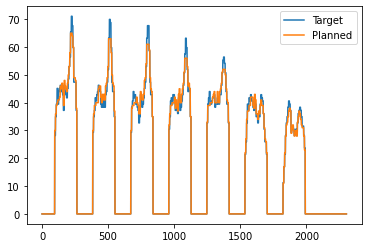

In [20]:
# and compare the planned staffing curve with the target

plt.plot(week2Planner.getTargetStaffing(), label="Target")
plt.plot(week2Planner.getPlannedStaffing(), label="Planned")
plt.legend()
plt.show()

In [21]:
# the optimization report 

print(week2Planner.getReport())


          turning length: 7
                 week n°: 0
             slot length: 5 minutes
               agents n°: 129
         target staffing: 4042.50 hrs
      simulated staffing: 4042.50 hrs

   comfort energy weight: 0.00000

         annealing steps: 72
       temperature range: 16.00000 -> 0.00014
    temperature schedule: 0.85
       optimization time: 3.8 minutes

         staffing energy: 162.52092 -> 2.63742
          comfort energy: 81061.71429 -> 137885.14286
            TOTAL ENERGY: 162.52092 -> 2.63742

     day by day staffing:
                 day   1: 659.50 hrs (target 657.29 hrs error -0.34%)
                 day   2: 636.50 hrs (target 630.78 hrs error -0.91%)
                 day   3: 618.50 hrs (target 617.80 hrs error -0.11%)
                 day   4: 605.50 hrs (target 603.13 hrs error -0.39%)
                 day   5: 598.50 hrs (target 598.62 hrs error 0.02%)
                 day   6: 500.50 hrs (target 499.32 hrs error -0.24%)
                 day   7: 